In [1]:
import numpy as np  
import pandas as pd
import xarray as xr
from dbfread import DBF
import dbf
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib import rcParams
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
from cartopy.io.shapereader import Reader
import cartopy.io.shapereader as shpreader
import math
from matplotlib import patches
from tqdm import tqdm
import os
import cmaps
from matplotlib.colors import ListedColormap

In [2]:
# 指定两个dbf文件路径
filename1 = "./dataset/SI.dbf"
filename2 = "./dataset/SP.dbf"

In [3]:
# 指定要读取的列名
columns = ['SID', 'year', 'BASIN', 'SUBBASIN', 'NAME',
           'ISO_TIME', 'NATURE', 'LAT', 'LON', 'USA_ATCFID', 
           'DIST2LAND', 'USA_STATUS', 'USA_WIND','WMO_WIND']

# 读取dbf文件中指定列名的数据
data1 = []
for record in DBF(filename1):
    row = []
    for column in columns:
        row.append(record[column])
    data1.append(row)

data2 = []
for record in DBF(filename2):
    row = []
    for column in columns:
        row.append(record[column])
    data2.append(row)

In [4]:
# 将数据转换为DataFrame
df1 = pd.DataFrame(data1, columns=columns)  #168730row
df2 = pd.DataFrame(data2, columns=columns)  #75937row


df1_s = df1[df1['DIST2LAND'] != 0]  #共98866行

df2_s = df2[df2['DIST2LAND'] != 0]  #共50312行


In [5]:
# 筛选出年份在1980-2022年内的数据
df1_year = df1_s[(df1_s['year'] >= 1980) & (df1_s['year'] <= 2023)]

# 筛选出USA_WIND大于等于35的数据
df1_w = df1_year[df1_year['USA_WIND'] >= 35]

# 检查SID是否有重复，若有重复则保留'USA_WIND'列最接近35的那一行数据
df1_SID = df1_w.sort_values(by=['SID', 'USA_WIND'])  #按照 SID 和 USA_WIND 列进行升序排序，即先按照 SID 排序，如果 SID 相同，则按照 USA_WIND 排序。
df1_SID.drop_duplicates(subset=['SID'], keep='first', inplace=True)  #若SID重复，保留这些行的第一个

# df2筛选同理
df2_year = df2_s[(df2_s['year'] >= 1980) & (df2_s['year'] <= 2023)]
df2_w = df2_year[df2_year['USA_WIND'] >= 0]
df2_SID = df2_w.sort_values(by=['SID', 'USA_WIND'])  
df2_SID.drop_duplicates(subset=['SID'], keep='first', inplace=True)

In [6]:
# 按照 'year'，'LAT' 和 'LON' 进行分组，并统计每个组的大小
df1_count = df1_SID.groupby(['year', 'LAT', 'LON']).size().reset_index(name='tc')
df2_count = df2_SID.groupby(['year', 'LAT', 'LON']).size().reset_index(name='tc')

# 将两个 DataFrame 拼接在一起
df_concat = pd.concat([df1_count, df2_count], axis=0)
df_concat = df_concat.reset_index(drop=True)
# df_concat

In [19]:
# 创建 'lat' 和 'lon' 的坐标数组
#lat = np.arange(-40,0.5,2.5)  # lat 从 0° 到 40°S，步长 2.5°
lat = np.arange(0, -45, -2.5)  # lat 从 0° 到 40°S，步长 2.5°
# lat = np.arange(0, -40.5, -2.5)  # lat 从 0° 到 40°S，步长 2.5°
lon = np.arange(0, 360, 2.5)  # lon 从 0 到 360，步长 2.5°

In [20]:
def tc_creat(startYear, endYear, lat, lon):
    # 创建 'tc' 变量，并将其写入 DataArray 对象
    tc = xr.DataArray(
        data=np.zeros((len(np.arange(startYear, endYear)), len(lat), len(lon))),
        dims=('year', 'lat', 'lon'),
        coords={'year': np.arange(startYear, endYear), 'lat': lat, 'lon': lon},
    )
    return tc

def sort_year_and_reset_index(df):
    df = df.sort_values(by=['year'],ascending=[True])
    df = df.reset_index(drop=True)
    return df

tc1980 = tc_creat(1980, 2007, lat, lon)

tc2009 = tc_creat(2009, 2024, lat, lon)

df1980 = sort_year_and_reset_index(df_concat[(df_concat['year'] <= 2006)])

df2009 = sort_year_and_reset_index(df_concat[(df_concat['year'] >= 2009)])

In [71]:
def tc_write(df,tc, num_year, lat, lon):
# 将每个格点每年生成的台风数量写入 'tc' 变量.iterrows()
# 将 DataFrame 表中的数据写入 'tc' 变量中相应的位置
    for _, row in df.iterrows():
        year, lat, lon, count = row.values
    #     print(_, year, lat, lon, count)
        year = int(year)                  # 将 year 转换为整数类型
        lat_idx = int(round(-lat / 2.5))  # 计算 lat 在 'tc' 中的索引
        lon_idx = int(round(lon / 2.5))   # 计算 lon 在 'tc' 中的索引
        tc[year-num_year, lat_idx, lon_idx-1] = count
    return tc

def year_mean_huadong(year, lat, lon):
    year_mean_hudong_ = np.zeros((18, 144),dtype=float)
    for i in range(year-2, year+3):
        tcYear = tc_creat(i, i+1, lat, lon)
        dfYear = sort_year_and_reset_index(df_concat[(df_concat['year'] == i)])
        tcYear2Next = tc_write(dfYear, tcYear, i, lat, lon)
        year_mean_hudong_ += tcYear2Next[0].data
    year_mean_hudong_ = year_mean_hudong_/5

#     tcYear2Year = tc_creat(year, year+1, lat, lon)
#     tcYear2Year[0].data = year_mean_hudong
    return year_mean_hudong_

def phase_mean_hua_dong(startYear, endYear):
    '''
    输入起始年
    输入xdarray 年滑动平局
    '''
    # 创建空tc
    tc_tmp = tc_creat(startYear, endYear, lat, lon)
    # 遍历起始年份
    for year in range(startYear, endYear):
        yearMeanHuaDong = year_mean_huadong(year, lat, lon)
        # 赋值year的滑动平均
        tc_tmp.data[year-startYear] = yearMeanHuaDong
    return tc_tmp

In [72]:
tc1982to2007 = phase_mean_hua_dong(1982, 2007)


In [73]:
tc2011to2020 = phase_mean_hua_dong(2011, 2020)

In [47]:
tc1982to2004.shape

(25, 18, 144)

In [74]:
def compute_tc_year(startYear, endYear):
    # 按照年份进行分组，并计算SI每个年份的台风总数量
    df1_total = df1_count.groupby('year')['tc'].sum().reset_index()

    # 新建一个包含所有年份的 DataFrame（由于2000年前为0，我这里直接从2000年开始）
    years = range(startYear, endYear)
    df1_total_result = pd.DataFrame({'year': years})
    # 合并两个 DataFrame
    df1_total_result = pd.merge(df1_total_result, df1_total, on='year', how='left')
    # 将缺失值填充为 0
    df1_total_result['tc'] = df1_total_result['tc'].fillna(0)
    SI_total = df1_total_result['tc'].values
    return SI_total

SI_total_1980 = compute_tc_year(1980, 2009)
SI_total_2009 = compute_tc_year(2009, 2022)

In [75]:
def HuaDong_mean(SI_total):
    '''
    计算滑动平均 
    '''
    ls = []
    length = SI_total.shape[0]
    for i in range(2, length-2):
        # 计算i的前后各2个数的平均
        tmp = SI_total[i-2]+SI_total[i-1]+SI_total[i]+SI_total[i+1]+SI_total[i+2]
        ls.append(tmp / 5)
    return np.array(ls)
    

SI_1980 = HuaDong_mean(SI_total_1980)
SI_2009 = HuaDong_mean(SI_total_2009)

In [59]:
SI_1980.shape

(25,)

In [62]:
SI_2009.shape

(9,)

In [76]:
def compute_regress(tc, SI_total):
    # 创建3个空数组存放回归系数和p值
    slope = np.full((tc.shape[1], tc.shape[2]), np.nan)
    r = np.full((tc.shape[1], tc.shape[2]), np.nan)
    p_value = np.full((tc.shape[1], tc.shape[2]), np.nan)
    # 循环每个格点计算回归系数和p值
    # 第一个循环是lat的个数
    for i in tqdm(range(9)):
        # 第二个循环是lon的点个数
        for j in range(72):
            # 计算多年数据相加结果
            total = tc[:,i,j].sum()
            # 仅当多年数据相加结果大于0时进行回归分析
            if total > 0:
                slope[i,j],_,r[i,j],p_value[i,j],_ = linregress(SI_total,tc[:,i,j])
    return slope, p_value

In [77]:
slope1982, p_value1982 = compute_regress(tc1982to2007, SI_1980)

100%|██████████| 9/9 [00:00<00:00, 26.72it/s]


In [78]:
slope2009, p_value2009 = compute_regress(tc2011to2020, SI_2009)

100%|██████████| 9/9 [00:00<00:00, 30.97it/s]


In [79]:
print("Slope 1980 MAX: %.10f and the MIN: %.10f"%(np.nanmax(slope1982), np.nanmin(slope1982)))

print("Slope 2007 MAX: %.10f and the MIN: %.10f"%(np.nanmax(slope2009), np.nanmin(slope2009)))

Slope 1980 MAX: 0.1600000000 and the MIN: -0.1236842105
Slope 2007 MAX: 0.1801896733 and the MIN: -0.1464699684


In [80]:
lon = tc1980.lon
lat = tc1980.lat

In [81]:
# 显著性打点设置为95%
area1 = np.where(p_value1982 < 0.05)
area2 = np.where(p_value2009 < 0.05)
nx,ny = np.meshgrid(lon,lat)

In [ ]:
# 自定义色标
newcolors_1=[
       [0.14117647, 0.        , 0.84705882, 1.        ],
       [0.15686275, 0.34117647, 1.        , 1.        ],
       [0.23921569, 0.52941176, 1.        , 1.        ],
       [0.3372549 , 0.69019608, 1.        , 1.        ],
       [0.45882353, 0.82745098, 1.        , 1.        ],
       [0.6       , 0.91764706, 1.        , 1.        ],
       [1.        , 0.83921569, 0.6       , 1.        ],
       [1.        , 0.6745098 , 0.45882353, 1.        ],
       [1.        , 0.47058824, 0.3372549 , 1.        ],
       [1.        , 0.23921569, 0.23921569, 1.        ],
       [0.84705882, 0.08235294, 0.18431373, 1.        ],
       [0.64705882, 0.        , 0.12941176, 1.        ]
]
newcmap_1 = ListedColormap(newcolors_1[::1])
newcmap_1

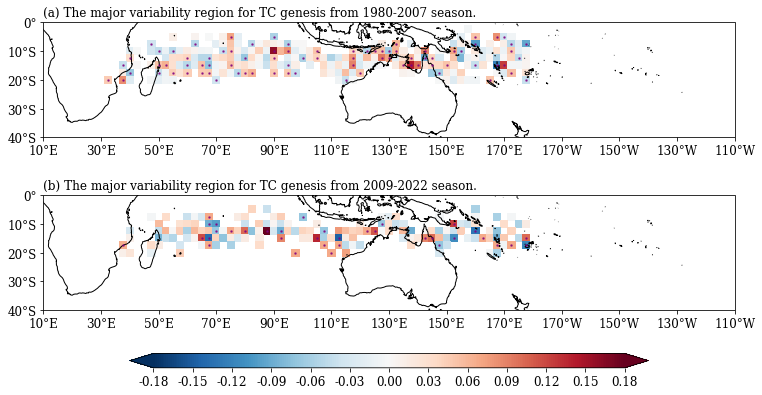

In [84]:
from matplotlib import colors,cm
import matplotlib as mpl

# 设置字体
config = {
    "font.family": 'serif',
    "font.size": 12,
    "mathtext.fontset":'stix',
    'axes.unicode_minus': False 
         }
rcParams.update(config)

MAX = 0.18
MIN = -0.18

fig = plt.figure(figsize=(12,8))

proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (10,240,-40,0)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

ax = fig.add_axes([0.1, 0.4, 0.8, 0.6],projection = proj)
ax.set_extent(img_extent, crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face',facecolor=cfeature.COLORS['land'])
#ax.add_feature(land,facecolor='0.75')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_xticks(np.arange(leftlon,rightlon+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
c1 = ax.pcolor(lon,lat, slope1982, zorder=0, vmin=MIN, vmax=MAX, 
               transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r
#                cmap=newcmap_1
              )
sig1 = ax.scatter(nx[area1], ny[area1],marker = '.',s=6, linewidths=1.3, c='purple',alpha=0.7,transform=ccrs.PlateCarree())
ax.set_title('(a) The major variability region for TC genesis from 1980-2007 season.',loc='left',fontsize =12)


# ========== 图2 =============
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.6],projection = proj)
ax1.set_extent(img_extent, crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face',facecolor=cfeature.COLORS['land'])
#ax.add_feature(land,facecolor='0.75')
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax1.set_xticks(np.arange(leftlon,rightlon+20,20), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
c1 = ax1.pcolor(lon,lat, slope2009, zorder=0, vmin=MIN, vmax=MAX, 
                transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r
#                 cmap=newcmap_1
               )
sig1 = ax1.scatter(nx[area2], ny[area2],marker = '.',s=6, linewidths=1.3, c='purple',alpha=0.7,transform=ccrs.PlateCarree())
ax1.set_title('(b) The major variability region for TC genesis from 2009-2022 season.',loc='left',fontsize =12)


# colorbar
position = fig.add_axes([0.2, 0.20,  0.6, 0.025]) # 最下面位置
norm = colors.Normalize(vmin=MIN, vmax=MAX)    #确定colormap的最大最小值
fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,
                                       cmap=plt.cm.RdBu_r
                                      ),
                 cax = position,
                 orientation='horizontal',
                 ticks=np.arange(MIN, MAX+0.01, 0.03).tolist(), # colorbar分片                                                 
                 extend='both',
#                  label =mul_symbol_text+'1e+06',
                fraction=0.02) 
# position=fig.add_axes([0.2, 0.22,  0.6, 0.025])
# cmap_ticks = [i for i in np.arange(MIN, MAX+0.01, 0.03)]
# fig.colorbar(c1,cax=position,ticks=cmap_ticks,orientation='horizontal',format='%.2f')

plt.savefig('TC生成频率.png', dpi=600, bbox_inches='tight',pad_inches = 0.2)
plt.show()

In [ ]:
# 设置字体
config = {
    "font.family": 'serif',
    "font.size": 12,
    "mathtext.fontset":'stix',
    'axes.unicode_minus': False 
         }
rcParams.update(config)

fig = plt.figure(figsize=(12,8))

proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (10,240,-40,0)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

ax = fig.add_axes([0.1, 0.1, 0.8, 0.6],projection = proj)
ax.set_extent(img_extent, crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face',facecolor=cfeature.COLORS['land'])
#ax.add_feature(land,facecolor='0.75')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_xticks(np.arange(leftlon,rightlon+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
c1 = ax.pcolor(lon,lat, slope1980, zorder=0, vmin=-0.06, vmax=0.06, transform=ccrs.PlateCarree(), cmap=newcmap_1)
sig1 = ax.scatter(nx[area1], ny[area1],marker = '.',s=6, linewidths=1.3, c='purple',alpha=0.7,transform=ccrs.PlateCarree())
ax.set_title('(a) The major variability region for TC genesis from 1980-2004 season.',loc='left',fontsize =12)
# colorbar
position=fig.add_axes([0.2, 0.22,  0.6, 0.025])
cmap_ticks = [-0.05, -0.04, -0.03, -0.02, -0.01, 0, 0.01, 0.02, 0.03, 0.04, 0.05]
fig.colorbar(c1,cax=position,ticks=cmap_ticks,orientation='horizontal',format='%.2f')

plt.savefig('TC生成频率1980.png', dpi=600, bbox_inches='tight',pad_inches = 0.2)
plt.show()

In [ ]:
# 设置字体
config = {
    "font.family": 'serif',
    "font.size": 12,
    "mathtext.fontset":'stix',
    'axes.unicode_minus': False 
         }
rcParams.update(config)

fig = plt.figure(figsize=(12,8))

proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (10,240,-40,0)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

ax = fig.add_axes([0.1, 0.1, 0.8, 0.6],projection = proj)
ax.set_extent(img_extent, crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face',facecolor=cfeature.COLORS['land'])
#ax.add_feature(land,facecolor='0.75')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_xticks(np.arange(leftlon,rightlon+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
c1 = ax.pcolor(lon,lat, slope2007, zorder=0, vmin=-0.06, vmax=0.06, transform=ccrs.PlateCarree(), cmap=newcmap_1)
sig1 = ax.scatter(nx[area1], ny[area1],marker = '.',s=6, linewidths=1.3, c='purple',alpha=0.7,transform=ccrs.PlateCarree())
ax.set_title('(b) The major variability region for TC genesis from 2007-2023 season.',loc='left',fontsize =12)
# colorbar
position=fig.add_axes([0.2, 0.22,  0.6, 0.025])
cmap_ticks = [-0.05, -0.04, -0.03, -0.02, -0.01, 0, 0.01, 0.02, 0.03, 0.04, 0.05]
fig.colorbar(c1,cax=position,ticks=cmap_ticks,orientation='horizontal',format='%.2f')

plt.savefig('TC生成频率2007.png', dpi=600, bbox_inches='tight',pad_inches = 0.2)
plt.show()